In [2]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [3]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys

if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [4]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [6]:
last_date = '2022-12-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World']#.query(f'date < "{last_date}"')

syn_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/syn_clade_stats_SARS_CoV_2/'
assert os.path.exists(syn_clade_stats_SARS_CoV_2_folder)

syn_clade_statistics_SARS_CoV_2_World = pd.read_csv(syn_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
syn_clade_statistics_SARS_CoV_2_World = syn_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [7]:
nonsyn_all_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_all_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_all_clade_stats_SARS_CoV_2_folder)

nonsyn_all_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_all_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_all_clade_statistics_SARS_CoV_2_World = nonsyn_all_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')


In [8]:
nonsyn_S_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_S_clade_stats_SARS_CoV_2/'
assert os.path.exists(nonsyn_S_clade_stats_SARS_CoV_2_folder)
nonsyn_S_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_S_clade_statistics_SARS_CoV_2_World = nonsyn_S_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [9]:
nonsyn_RBD_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/RBD_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_RBD_clade_stats_SARS_CoV_2_folder)

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_RBD_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = nonsyn_RBD_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [10]:
nonsyn_S_clade_statistics_driver_mutations = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')
nonsyn_RBD_clade_statistics_driver_mutations = pd.read_csv(nonsyn_RBD_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')

In [11]:
driver_mutation_statistics_with_bg = pd.read_csv('data/driver_mutation_statistics_with_bg.tsv', sep = '\t')

In [12]:
nonsyn_S_clade_statistics_driver_mutations['Driver_Mutation']
#driver_mutation_to_variant map 

driver_to_variant_map = driver_mutation_statistics_with_bg[['Driver_Mutation','Variant']].set_index('Driver_Mutation').to_dict()['Variant']


In [13]:
nonsyn_S_clade_statistics_driver_mutations['Variant'] = nonsyn_S_clade_statistics_driver_mutations['Driver_Mutation'].map(driver_to_variant_map)
syn_clade_statistics_SARS_CoV_2_World['Variant'] = syn_clade_statistics_SARS_CoV_2_World['Clade'].map(driver_to_variant_map)
nonsyn_RBD_clade_statistics_driver_mutations['Variant'] = nonsyn_RBD_clade_statistics_driver_mutations['Driver_Mutation'].map(driver_to_variant_map)

In [14]:
reference_date = pd.to_datetime('2020-01-01')
syn_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(syn_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_all_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_all_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_S_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_S_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_RBD_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

In [15]:
driver_mutation_to_clade = driver_mutation_statistics_with_bg[['Driver_Mutation','Clade']].set_index('Driver_Mutation').to_dict()['Clade']

In [16]:
driver_mutation_statistics_with_bg.Variant.unique()

array(['1', '1C.2A.3A.4B', '1C.2B.3G', '1C.2D.3F', '1C.2B.3D', '1C.2B.3J',
       '1C.2B.3J.4D', '1C.2B.3J.4E', '1C.2B.3J.4G', '1C.2B.3J.4E.5N.6J',
       '1C.2B.3J.4E.5N', '1C.2B.3J.4E.5N.6K', '1C.2B.3J.4E.5N.6J.7D',
       '1C.2B.3J.4E.5N.6J.7E', '1C.2B.3J.4E.5N.6J.7D.8A'], dtype=object)

In [17]:
row = driver_mutation_statistics_with_bg.sample(1)
print(row)

      Clade Emergence_Time      Variant                Driver_Mutation  \
7604   7605     2022-06-22  1C.2B.3J.4G  F371S,P373S,F375S,A376T,S408R   

      Max_Realized_Sublineage_Freq  
7604                      0.000195  


In [18]:
driver_mutation_statistics_with_bg

,Clade,Emergence_Time,Variant,Driver_Mutation,Max_Realized_Sublineage_Freq
0,1,2019-12-31,1,NaN,1.000000
1,2,2020-02-11,1,"R509K,V510L",0.000811
2,3,2020-01-28,1,K378R,0.061610
3,4,2020-03-19,1,I468V,0.001814
4,5,2020-04-06,1,V367F,0.000075
...,...,...,...,...,...
18402,18403,2023-06-14,1C.2B.3J.4E.5N.6J.7E,"F375-,F375-,F375-",0.000018
18403,18404,2023-06-12,1C.2B.3J.4E.5N.6J.7E,G476S,0.000018
18404,18405,2023-07-08,1C.2B.3J.4E.5N.6J.7E,T346I,0.000706
18405,18406,2023-06-19,1C.2B.3J.4E.5N.6J.7E,K460N,0.000037


In [19]:
#pick a variant 
variant = driver_mutation_statistics_with_bg.sample(1)['Variant']
print(variant)

mutations = driver_mutation_statistics_with_bg.query(f'Variant == "{variant.values[0]}"')['Driver_Mutation']
# print(mutations.values)
clades = [driver_mutation_to_clade[mutation] for mutation in mutations.values]
print(len(clades))

15483    1C.2B.3J.4E.5N.6J
Name: Variant, dtype: object
2066


In [46]:
clades_in_variant_df = driver_mutation_statistics_with_bg.groupby('Variant')['Clade'].unique().to_dict()
clades_in_variant_df = pd.DataFrame(clades_in_variant_df.items(), columns = ['Variant','Clades'])

In [61]:
day_diff_vals = np.arange(nonsyn_RBD_clade_statistics_SARS_CoV_2_World['day_diff'].min(),nonsyn_RBD_clade_statistics_SARS_CoV_2_World['day_diff'].max())

variant_freq = np.zeros_like(day_diff_vals)

for i,day_diff in enumerate(day_diff_vals):
    clades_in_day = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.query(f'day_diff == {day_diff}')['Clade']
    variant_freq[i] = np.sum([clade in clades for clade in clades_in_day])


array([ -32,  -31,  -30, ..., 1368, 1369, 1370])

In [221]:

RBD_merged_df = pd.merge(nonsyn_RBD_clade_statistics_SARS_CoV_2_World, driver_mutation_statistics_with_bg[['Clade', 'Variant']], on='Clade')

RBD_time_series_df = RBD_merged_df.groupby(['Variant', 'day_diff']).agg({
    'Clade_Freq': 'sum'
}).reset_index()

# Rename columns to match the desired output
RBD_time_series_df.columns = ['Variant', 'day_diff', 'Freq']

In [226]:
syn_merged_df = pd.merge(syn_clade_statistics_SARS_CoV_2_World, driver_mutation_statistics_with_bg[['Clade', 'Variant']], on='Clade')
print(RBD_merged_df)


         Clade        Time  Sublineage_Freq    Clade_Freq  day_diff  \
0            1  2019-12-07     1.000000e+00  1.000000e+00       -25   
1            1  2019-12-08     1.000000e+00  1.000000e+00       -24   
2            1  2019-12-09     1.000000e+00  1.000000e+00       -23   
3            1  2019-12-10     1.000000e+00  1.000000e+00       -22   
4            1  2019-12-11     1.000000e+00  1.000000e+00       -21   
...        ...         ...              ...           ...       ...   
1902564  18407  2023-08-04     6.533307e-17  6.533307e-17      1311   
1902565  18407  2023-08-05     3.568337e-18  3.568337e-18      1312   
1902566  18407  2023-08-06     1.540825e-19  1.540825e-19      1313   
1902567  18407  2023-08-07     5.196052e-21  5.196052e-21      1314   
1902568  18407  2023-08-08     1.351505e-22  1.351505e-22      1315   

                      Variant  
0                           1  
1                           1  
2                           1  
3                  

In [ ]:
bg

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


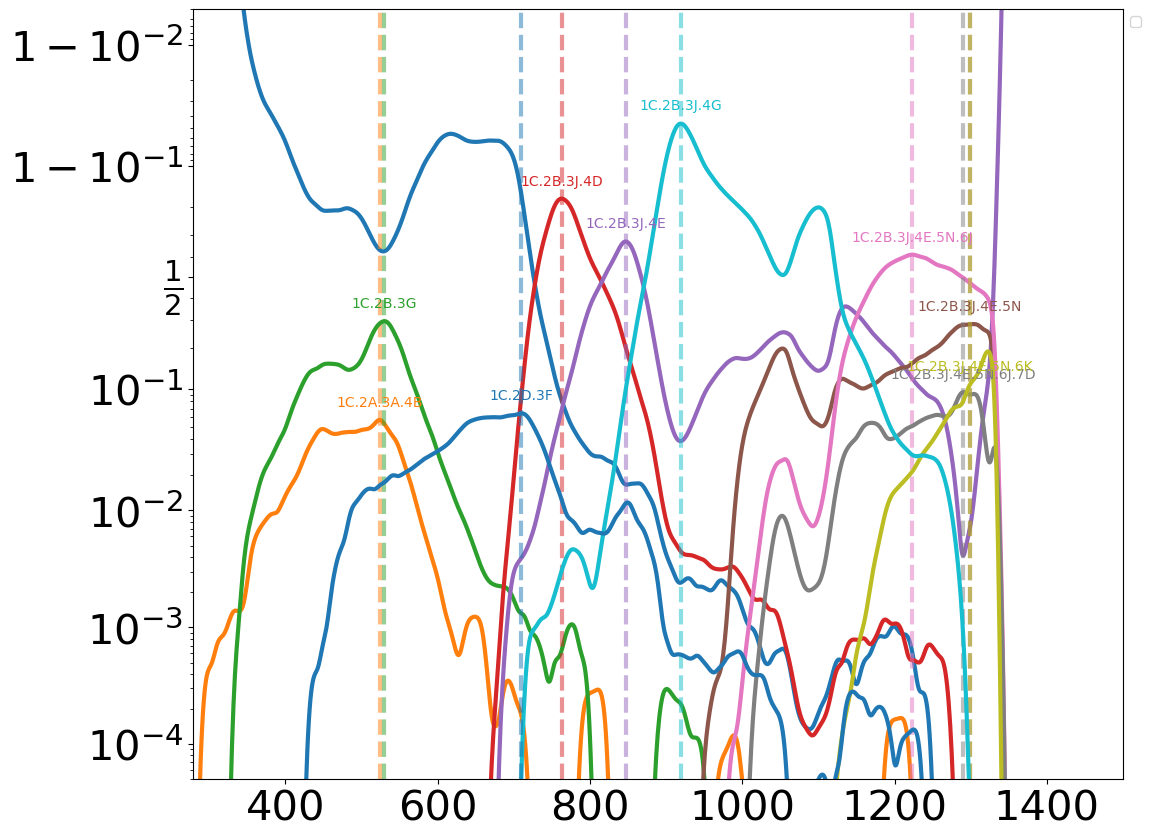

In [222]:
fig,ax = plt.subplots(figsize=(12,10))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=10)
ax.set_yscale('logit')
ax.set_ylim([5e-5,1-5e-3])
ax.set_xlim(left =279, right = 1500)#(279.0, 1149.75))
for variant in RBD_time_series_df['Variant'].unique():
    day_diff_vals = RBD_time_series_df.query(f'Variant == "{variant}"')['day_diff']
    freq_vals = RBD_time_series_df.query(f'Variant == "{variant}"')['Freq']
    if np.max(freq_vals) > 5e-2:
        
        l, = ax.plot(day_diff_vals, freq_vals, label=variant)
        variant_df = RBD_time_series_df.query(f'Variant == "{variant}" & day_diff < 1300')
        t_peak_freq = variant_df['day_diff'].iloc[np.argmax(variant_df['Freq'])]
        x_peak_freq = variant_df['Freq'].iloc[np.argmax(variant_df['Freq'])]
        #plot with same colors as lineplot
        ax.axvline(t_peak_freq, linestyle='--', alpha=0.5, color=l.get_color())
        ax.annotate(f'{variant}', (t_peak_freq, x_peak_freq), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color=l.get_color())

In [253]:
driver_mutation_statistics_syn

,Clade,Emergence_Time,Driver_Mutation,Max_Realized_Sublineage_Freq
0,1,2019-12-31,NaN,1.000000
1,2,2020-01-28,NaN,0.074760
2,3,2020-02-26,NaN,0.015009
3,4,2020-02-11,"R509K,V510L",0.000811
4,5,2020-02-05,NaN,0.003500
...,...,...,...,...
280328,280329,2023-07-10,"Q564H,S704L",0.000030
280329,280330,2023-06-28,NaN,0.000022
280330,280331,2023-06-26,NaN,0.000961
280331,280332,2023-06-23,NaN,0.000410


In [251]:
driver_mutation_statistics_syn = pd.read_csv('data/syn_clade_stats_SARS_CoV_2/driver_mutation_statistics.tsv', sep = '\t')

driver_mutation_statistics_syn

,Clade,Emergence_Time,Driver_Mutation,Max_Realized_Sublineage_Freq
0,1,2019-12-31,NaN,1.000000
1,2,2020-01-28,NaN,0.074760
2,3,2020-02-26,NaN,0.015009
3,4,2020-02-11,"R509K,V510L",0.000811
4,5,2020-02-05,NaN,0.003500
...,...,...,...,...
280328,280329,2023-07-10,"Q564H,S704L",0.000030
280329,280330,2023-06-28,NaN,0.000022
280330,280331,2023-06-26,NaN,0.000961
280331,280332,2023-06-23,NaN,0.000410


Text(0, 0.5, 'Variant Frequency')

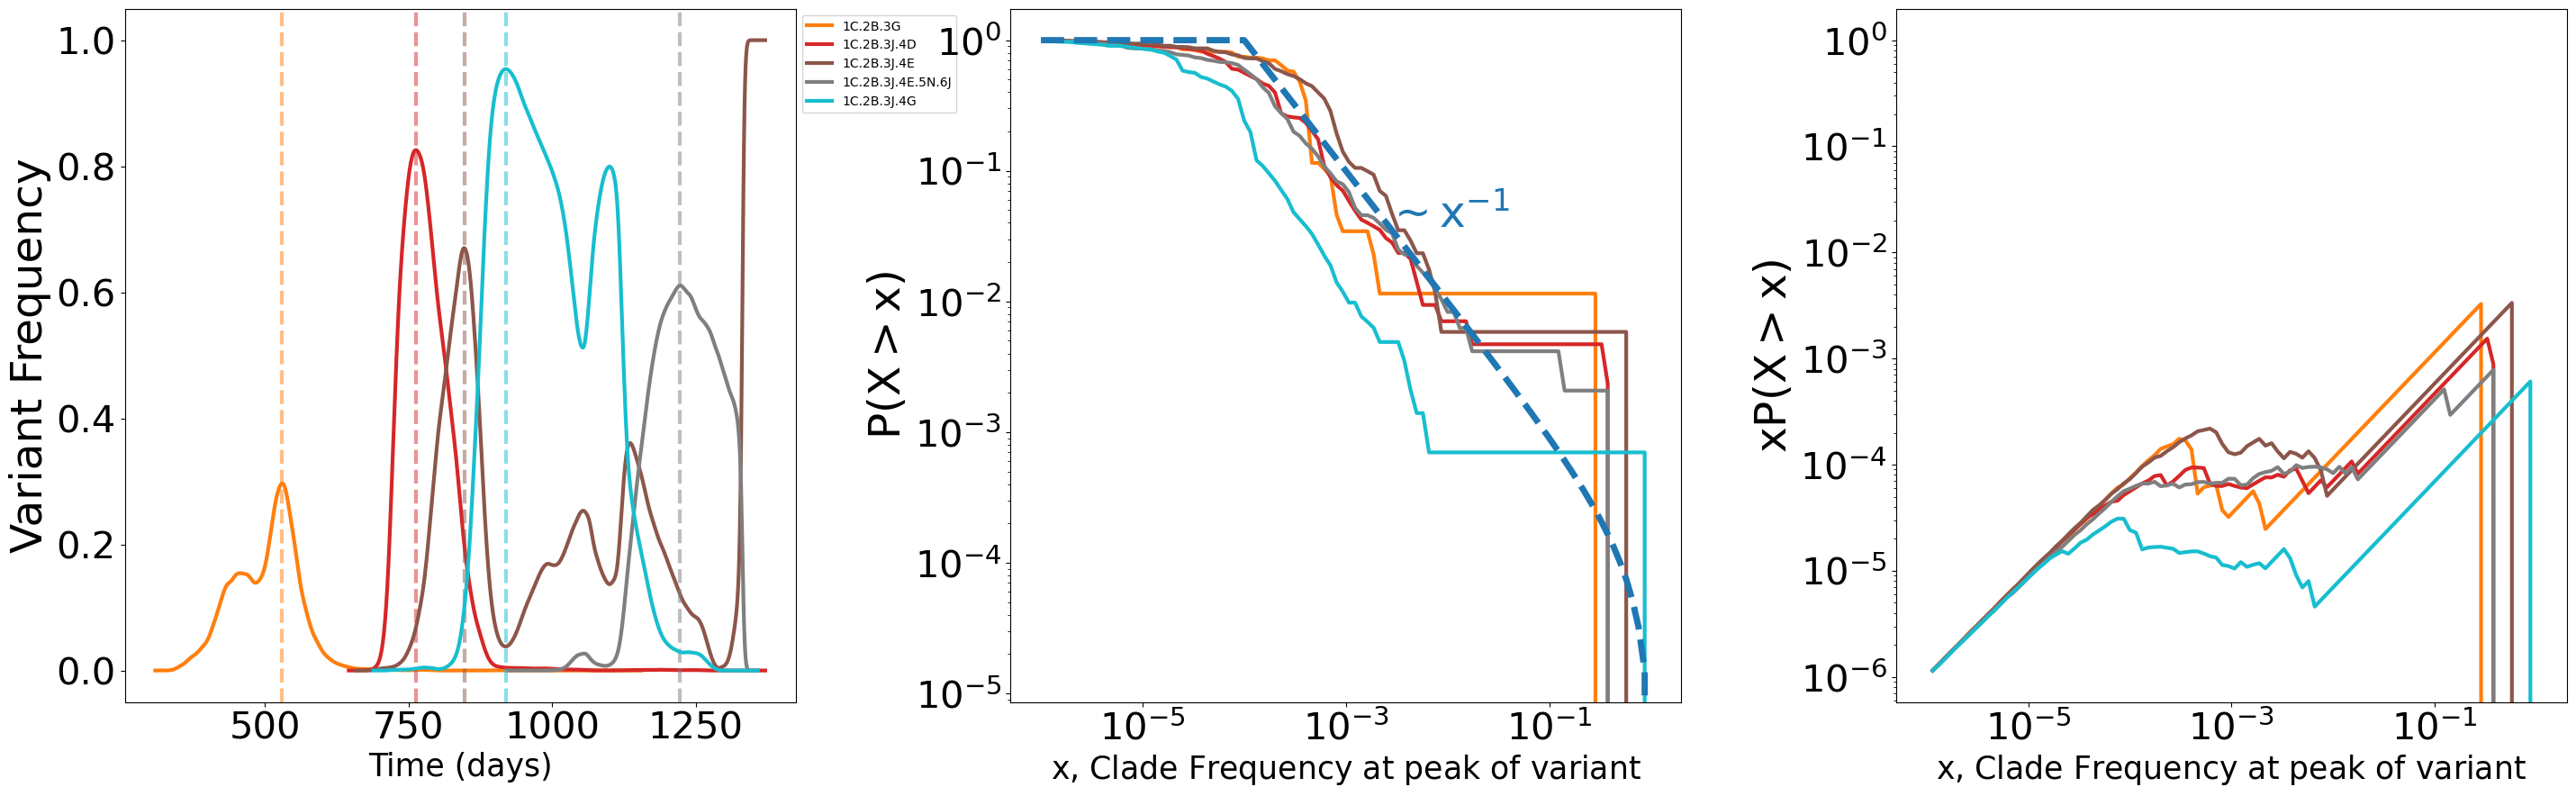

In [245]:
freq_bins = np.logspace(-6,0,100)
fig,ax= plt.subplots(1,3,figsize=(35,10))
plt.subplots_adjust(wspace=0.32)
for variant in RBD_time_series_df['Variant'].unique():
    variant_df = RBD_time_series_df.query(f'Variant == "{variant}" & day_diff < 1325')
    t_peak_freq = variant_df['day_diff'].iloc[np.argmax(variant_df['Freq'])]
    clades = driver_mutation_statistics_with_bg.query(f'Variant == "{variant}"')['Clade'].values
    # clade frequencies at t_peak_freq for clade in clades
    
    if len(RBD_merged_df.query(f'Variant == "{variant}" and day_diff == {t_peak_freq}')['Clade_Freq'])>100 and np.max(RBD_merged_df.query(f'Variant == "{variant}" and day_diff == {t_peak_freq}')['Clade_Freq']) > 5e-2:
        
        h,b, p = ax[-1].hist(RBD_merged_df.query(f'Variant == "{variant}" and day_diff == {t_peak_freq}')['Clade_Freq'], bins = freq_bins, cumulative=-1, histtype='step',density=True,alpha=0)
        
        l, = ax[-1].plot(b[1:], h*b[1:], label = f'{variant}')
        ax[1].plot(b[1:], h, label = f'{variant}', color = l.get_color())

        ax[0].plot(RBD_time_series_df.query(f'Variant == "{variant}"')['day_diff'], RBD_time_series_df.query(f'Variant == "{variant}"')['Freq'], label = f'{variant}', color = l.get_color())

        ax[0].axvline(t_peak_freq, linestyle='--', alpha=0.5, color=l.get_color())
        # ax[-1].axhline(len(clades), linestyle='--', color='black')
ax[-1].set_xscale('log')
ax[-1].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=10)
# ax[-1].set_ylim(bottom = 1)
l, = ax[1].plot(freq_bins,  np.minimum(100*freq_bins[0]/freq_bins * (1- freq_bins)/(1-freq_bins[0]),1), label = 'Neutral expectation', linestyle='--',lw=5)
        # ax[-1].set_title(f'Variant {variant}')
ax[1].annotate(r'$\sim x^{-1}$', (1e-2, 3e-2), textcoords="offset points", xytext=(0,10), ha='center', fontsize=35, color=l.get_color())
ax[-1].set_xlabel('$x$, Clade Frequency at peak of variant',fontsize=25)
ax[-1].set_ylabel(r'$x P(X > x)$',fontsize=35)
ax[1].set_xlabel('$x$, Clade Frequency at peak of variant',fontsize=25)
ax[1].set_ylabel(r'$P(X > x)$',fontsize=35)
ax[-1].set_xticks = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
ax[0].set_xlabel('Time (days)',fontsize=25)
ax[0].set_ylabel('Variant Frequency',fontsize=35)

In [246]:
driver_mutation_statistics_with_bg

,Clade,Emergence_Time,Variant,Driver_Mutation,Max_Realized_Sublineage_Freq
0,1,2019-12-31,1,NaN,1.000000
1,2,2020-02-11,1,"R509K,V510L",0.000811
2,3,2020-01-28,1,K378R,0.061610
3,4,2020-03-19,1,I468V,0.001814
4,5,2020-04-06,1,V367F,0.000075
...,...,...,...,...,...
18402,18403,2023-06-14,1C.2B.3J.4E.5N.6J.7E,"F375-,F375-,F375-",0.000018
18403,18404,2023-06-12,1C.2B.3J.4E.5N.6J.7E,G476S,0.000018
18404,18405,2023-07-08,1C.2B.3J.4E.5N.6J.7E,T346I,0.000706
18405,18406,2023-06-19,1C.2B.3J.4E.5N.6J.7E,K460N,0.000037


In [239]:
S_merged_df = pd.merge(nonsyn_S_clade_statistics_SARS_CoV_2_World,driver_mutation_statistics_with_bg[['Clade', 'Variant']], on='Clade')

S_time_series_df = S_merged_df.groupby(['Variant', 'day_diff']).agg({
    'Clade_Freq': 'sum'
}).reset_index()

S_time_series_df.columns = ['Variant', 'day_diff', 'Freq']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


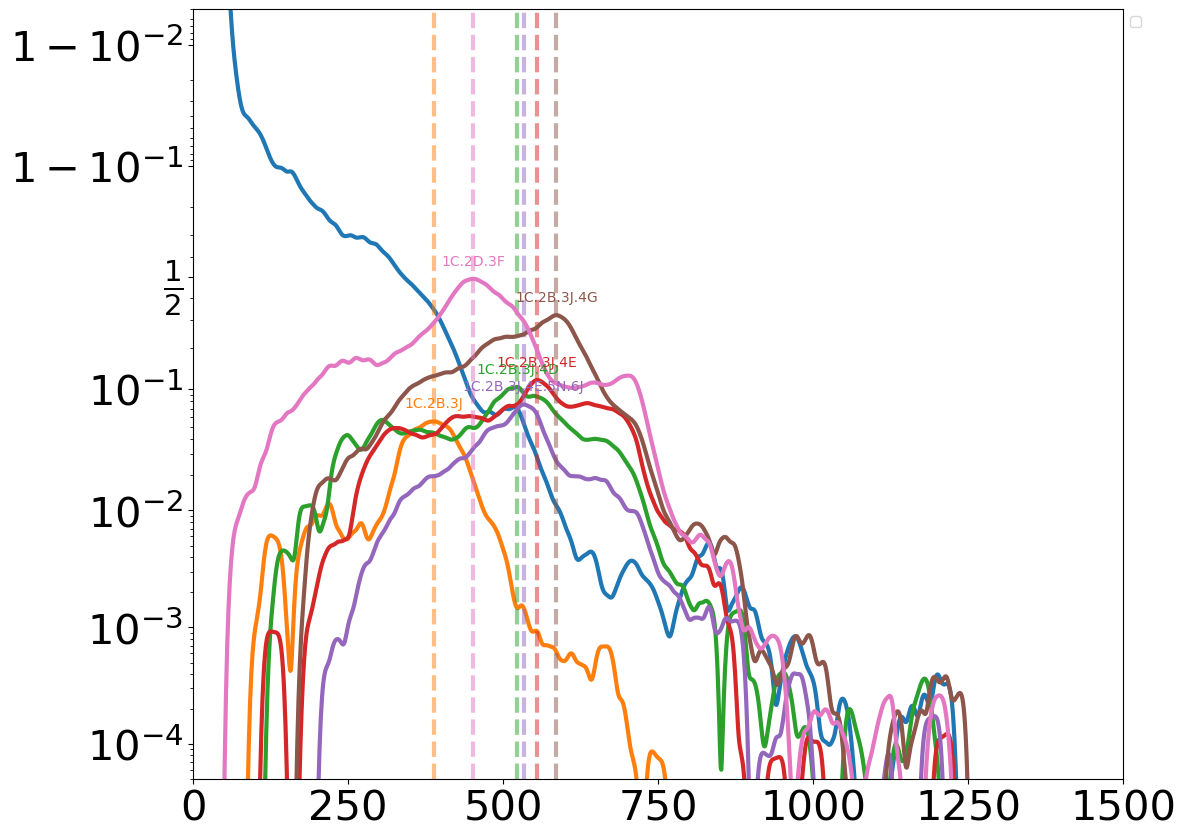

In [242]:
fig,ax = plt.subplots(figsize=(12,10))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=10)
ax.set_yscale('logit')
ax.set_ylim([5e-5,1-5e-3])
ax.set_xlim(left =0, right = 1500)#(279.0, 1149.75))
for variant in S_time_series_df['Variant'].unique():
    day_diff_vals = S_time_series_df.query(f'Variant == "{variant}"')['day_diff']
    freq_vals = S_time_series_df.query(f'Variant == "{variant}"')['Freq']
    if np.max(freq_vals) > 5e-2:
        
        l, = ax.plot(day_diff_vals, freq_vals, label=variant)
        variant_df = S_time_series_df.query(f'Variant == "{variant}" & day_diff < 1300')
        t_peak_freq = variant_df['day_diff'].iloc[np.argmax(variant_df['Freq'])]
        x_peak_freq = variant_df['Freq'].iloc[np.argmax(variant_df['Freq'])]
        #plot with same colors as lineplot
        ax.axvline(t_peak_freq, linestyle='--', alpha=0.5, color=l.get_color())
        ax.annotate(f'{variant}', (t_peak_freq, x_peak_freq), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color=l.get_color())